<a href="https://colab.research.google.com/github/randelln/FoodRec/blob/main/InceptionV3Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)


Mounted at /content/gdrive


In [ ]:
#import required libraries
import numpy as np
import os 
import keras
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
!unzip -q "/content/gdrive/MyDrive/UECFOOD/UEC.zip" -d "/content/UEC"

In [ ]:
import torch
torch.cuda.get_device_name(0)

'Tesla P4'

In [ ]:
#Variables to set image size, file path, and batch size
img_height, img_width = 299,299
train_data_dir = '/content/UEC'
validation_data_dir = '/content/UEC'
batch_size =16

In [ ]:
#Data Augemntation
#fill_mode - When shifting an image, there is space left over, fill_mode will fill that area
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range =0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range =40,
    width_shift_range =0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [ ]:
#Setup training data
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size = batch_size,
    subset="training",
    class_mode = 'categorical')

Found 9847 images belonging to 85 classes.


In [ ]:
#Setup validation data
validation_generator = datagen.flow_from_directory(
    
    validation_data_dir,
    target_size=(img_width,img_height),
    batch_size = batch_size,
    #Shuffle to be commented out when training data, and set to false when genereating metrics
    #shuffle = False,
    subset="validation",
    class_mode = 'categorical',
    )

Found 2424 images belonging to 85 classes.


In [ ]:
# Activation Function - Applied to convoluted values to increase the non-linearrity
# Pooling Layer - Used to reduce image size, and only keeps most important features of image
# Flatten - Transfroms multiple feature maps, into 1D Array
# Batch Normalization - Used to increased training speed and network performance
# Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

# Applying non-tuned InceptionV3 model
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(85,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)


In [ ]:
#Compile the model
model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#View model summary
model.summary()

In [ ]:
from keras.callbacks import History
from keras.callbacks import EarlyStopping

#Checkpoint used to save the best model throughout the epochs
#Using a csv logger to track epochs
checkpointer = ModelCheckpoint(filepath="/content/gdrive/MyDrive/UECInceptionV3/best_model.hdf5", verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/gdrive/MyDrive/UECInceptionV3/history_3class.log')
history = History()

In [ ]:
#Fitting the model(Training the model)
hist = model.fit(
    train_generator,
    shuffle = True,
    steps_per_epoch = 614,
    epochs = 30,callbacks=[history, checkpointer, csv_logger],
    validation_data = validation_generator,
    validation_steps= 151)

Epoch 1/30
614/614 [==============================] - 278s 440ms/step - loss: 4.9655 - accuracy: 0.0327 - val_loss: 4.5881 - val_accuracy: 0.1105

Epoch 00001: val_loss improved from inf to 4.58809, saving model to /content/gdrive/MyDrive/UECInceptionV3/best_model.hdf5
Epoch 2/30
614/614 [==============================] - 266s 433ms/step - loss: 4.4835 - accuracy: 0.1275 - val_loss: 4.2529 - val_accuracy: 0.1871

Epoch 00002: val_loss improved from 4.58809 to 4.25294, saving model to /content/gdrive/MyDrive/UECInceptionV3/best_model.hdf5
Epoch 3/30
614/614 [==============================] - 266s 433ms/step - loss: 4.1756 - accuracy: 0.1994 - val_loss: 3.9477 - val_accuracy: 0.2517

Epoch 00003: val_loss improved from 4.25294 to 3.94768, saving model to /content/gdrive/MyDrive/UECInceptionV3/best_model.hdf5
Epoch 4/30
614/614 [==============================] - 268s 436ms/step - loss: 3.8934 - accuracy: 0.2613 - val_loss: 3.6434 - val_accuracy: 0.3137

Epoch 00004: val_loss improved from

In [ ]:
#Print model accuracy
acc = model.evaluate(validation_generator, steps=len(validation_generator), verbose = 2)
print('%.2f'%(acc[1]*100))

152/152 - 47s - loss: 1.4320 - accuracy: 0.7380
73.80


In [ ]:
#Additional save model command
model.save('/content/gdrive/MyDrive/UECInceptionV3/inception_model.hdf5')

In [ ]:
tf.saved_model.save(model, '/content/gdrive/MyDrive/UECInceptionV3')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/UECMODEL/assets


<function matplotlib.pyplot.show>

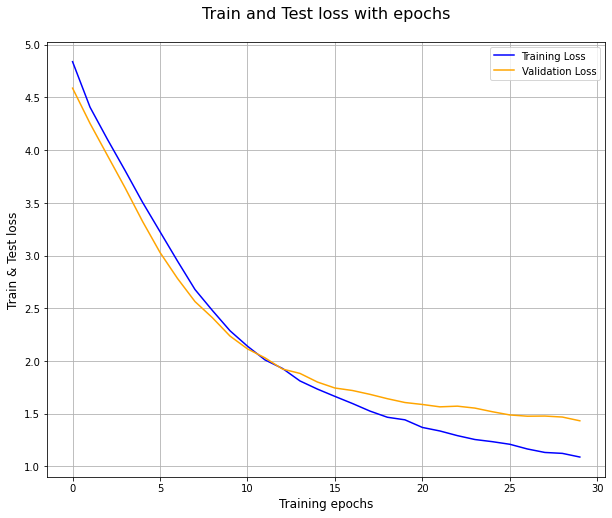

In [ ]:
#Plot loss graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(hist.history['loss'], color = 'blue', label = 'Training Loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'Validation Loss')
plt.grid(True)
plt.title("Train and Test loss with epochs\n", fontsize=16)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Train & Test loss", fontsize=12)
plt.legend(loc=0)

plt.show

<function matplotlib.pyplot.show>

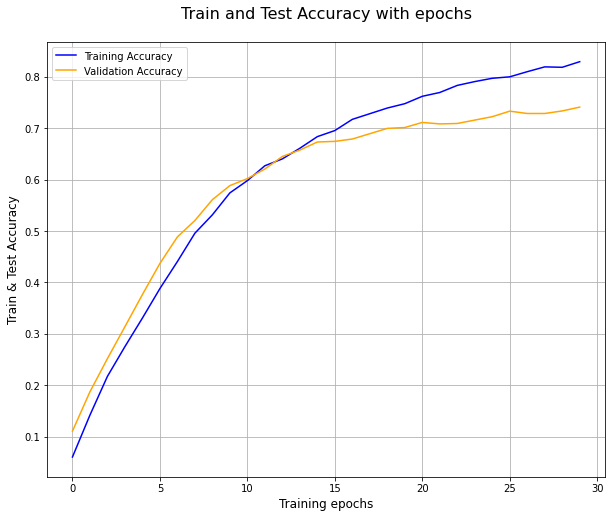

<Figure size 1440x1080 with 0 Axes>

In [ ]:
#Plot accuracy graph
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(hist.history['accuracy'], color = 'blue', label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'Validation Accuracy')
plt.grid(True)
plt.title("Train and Test Accuracy with epochs\n", fontsize=16)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Train & Test Accuracy", fontsize=12)
plt.legend(loc=0)
plt.figure(figsize=(20,15))
plt.show

In [ ]:
#Load model to produce predictions and metrics, after loading, then load data and perform necessary augmentation.
model = load_model('/content/gdrive/MyDrive/UECInceptionV3/best_model.hdf5')

In [ ]:
from sklearn import metrics
Y_pred = model.predict(validation_generator)
fpr, tpr, thresholds = metrics.roc_curve(validation_generator.classes, np.argmax(Y_pred, axis=1), pos_label=1)

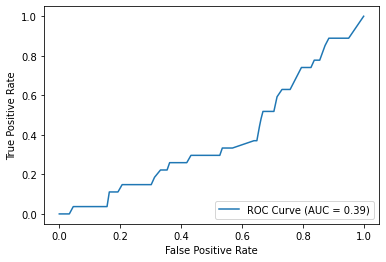

In [ ]:

import matplotlib.pyplot as plt
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='ROC Curve')
display.plot()
plt.show()

In [ ]:
#Names of classes, to be used for confusion matrix and classification report
target_names = [ 'rice', 
                'tempura bowl',
                'bibimbap',
                'toast',
                'croissant',
                'roll bread',
                'rasin bread','chip butty','hamburger','pizza','sandwiches','eels on rice','udon noodle','tempura udon','soba noodle','ramen noodle','beef noodle','tensin noodle','fried noodle',
                    'spaghetti',
                    'Japanese-style pancake',
                    'takoyako',
                    'pilaf',
                    'gratin',
                    'sauteed vegetables',
                    'croquette',
                    'grilled eggplant',
                    'sauteed spinach',
                    'vegetable tempura',
                    'miso soup',
                    'potage',
                    'sausage',
                    'oden',
                    'chicken and egg on rice',
                    'omelet',
                    'ganmodoki',
                    'jiaozi',
                    'stew',
                    'teriyaki grilled fish',
                    'fried fish',
                    'grilled salmon',
                    'salmon meuniere',
                    'sashimi',
                    'grilled pacific saury',
                    'pork cutlet on rice',
                    'sukiyaki',
                    'sweet and sour pork',
                    'lightly roasted fish',
                    'steamed egg hotchpotch',
                    'tempura',
                    'fried chicken',
                    'sirloin cutlet',
                    'nanbanzuke',
                    'boiled fish',
                    'seasoned beef with potatoes',
                    'beef curry',
                    'hambarg steak',
                    'steak',
                    'dried fish',
                    'ginger pork saute',
                    'spicy chili-flavoured tofu',
                    'yakitori',
                    'cabbage roll',
                    'omelet',
                    'egg sunny-side up',
                    'natto',
                    'sushi',
                    'cold tofu',
                    'egg roll',
                    'chilled noodle',
                    'stir-fried beef and peppers',
                    'simmered pork',
                    'boiled chicken and vegetables',
                    'sashimi bowl',
                    'sushi bowl',
                    'fish-shaped pancake with bean jam',
                    'shrimp with chilli sauce',
                    'chicken rice',
                    'roast chicken',
                    'steamed meat dumpling',
                    'omelet with fried rice',
                    'cutlet curry',
                    'spaghetti meat sauce',
                    'fried shrimp',
                    'fried rice']



In [ ]:
#Generate and plot confustion matrix
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.pyplot import figure

figure(figsize=(70, 70))

Y_pred = model.predict(validation_generator, 2424)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)


plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
#plt.margins(0.9)

#plt.subplots_adjust(bottom = 0.15)
plt.xticks([],  target_names)
plt.yticks([], target_names)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [ ]:
#Produce classification report for F1 scores
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(validation_generator, 2424)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')

print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[121   0   0 ...   0   0   0]
 [  0  18   0 ...   0   0   0]
 [  0   0  19 ...   0   0   0]
 ...
 [  0   0   0 ...  13   0   0]
 [  0   0   0 ...   0  17   0]
 [  1   0   0 ...   0   0  29]]
Classification Report
                                   precision    recall  f1-score   support

                             rice       0.95      0.98      0.96       124
                     tempura bowl       0.72      0.67      0.69        27
                         bibimbap       0.90      0.86      0.88        22
                            toast       0.75      0.70      0.72        43
                        croissant       0.88      0.88      0.88        24
                       roll bread       0.84      1.00      0.91        21
                      rasin bread       0.90      0.90      0.90        20
                       chip butty       0.56      0.62      0.59        29
                        hamburger       0.87      0.89      0.88        46
                  